In [2]:
# Import libraries

import torch
from torch import nn
from torchvision.datasets import OxfordIIITPet
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image

In [12]:
# For our puffer surver we need to browse via a proxy!!
import os
# Set HTTP and HTTPS proxy
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [ ]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
import numpy as np
from einops import rearrange

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels = 3,out_channels=1,ConV=False, patch_size = 4,
                 n_patch= 36 , emb_size = 128):
        self.patch_size = patch_size
        # self.stop_at_conv = stop_at_conv
        self.res_att = None
        # self.in_channels = in_channels
        super().__init__()
        if ConV:
            # patch_size = int(patch_size / 2)
            self.patch_size = patch_size
            self.projection = nn.Sequential(
                # break-down the image in s1 x s2 patches and flat them
                Rearrange('b (h w) e -> b e h w',h=n_patch,w=n_patch),
                # Rearrange('b n e -> b 1 n e'),
                torch.nn.Conv2d(in_channels,out_channels,2,2),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.1),
                Rearrange('b c h w -> b (h w) c'),
                nn.Linear(out_channels, emb_size)
                
            )
        else:
            self.projection = nn.Sequential(
                # break-down the image in s1 x s2 patches and flat them
                Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
                nn.Linear(patch_size * patch_size * in_channels, emb_size)
            )
            
    # def _get_rest_att(self): return self.res_att

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection[0](x)
        x = self.projection[1](x)
        if len(self.projection) > 2: 
            x = self.projection[2](x)
            x = self.projection[3](x)
            x = self.projection[4](x)
            x = self.projection[5](x)
        return x
    
# # Run a quick test
# sample_datapoint = torch.unsqueeze(dataset[0][0], 0)
# print("Initial shape: ", sample_datapoint.shape)
# embedding = PatchEmbedding()(sample_datapoint)
# print("Patches shape: ", embedding.shape)

In [49]:
embedding = PatchEmbedding()(sample_datapoint)

torch.Size([1, 3, 144, 144])
torch.Size([1, 1296, 48])


In [10]:
embedding.shape

torch.Size([1, 1296, 128])

In [17]:
from einops import rearrange

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout):
        super().__init__()
        self.n_heads = n_heads
        self.att = torch.nn.MultiheadAttention(embed_dim=dim,
                                               num_heads=n_heads,
                                               dropout=dropout)
        self.q = torch.nn.Linear(dim, dim)
        self.k = torch.nn.Linear(dim, dim)
        self.v = torch.nn.Linear(dim, dim)

    def forward(self, x):
        q = self.q(x)
        k = self.k(x)
        v = self.v(x)
        attn_output, attn_output_weights = self.att(x, x, x)
        return attn_output

In [13]:
Attention(dim=128, n_heads=4, dropout=0.)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [18]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [15]:
norm = PreNorm(128, Attention(dim=128, n_heads=4, dropout=0.))
norm(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [19]:
class FeedForward(nn.Sequential):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
ff = FeedForward(dim=128, hidden_dim=256)
ff(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [20]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [9]:
residual_att = ResidualAdd(Attention(dim=128, n_heads=4, dropout=0.))
residual_att(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 128])

In [21]:
from einops import rearrange

class LessAttention(nn.Module):
    def __init__(self,n_patch, emb_dim):
        super().__init__()
        # self.fn = fn
        self.in_dim = emb_dim
        self.n_patch = n_patch
        # self.out_dim = int(emb_dim / 2)

        self.FC1 = torch.nn.Linear(self.in_dim, n_patch)
        self.FC2 = torch.nn.Linear(n_patch, n_patch)
    
    def get_out_dim(): return self.out_dim

    def forward(self, x):
        # x = self.fn(x)
        # print(x.shape)
        x = self.FC1(x)
        # print(x.shape)
        x =  torch.transpose(x, 1, 2)
        # print(self.n_patch)
        # print(x.shape)
        x = self.FC2(x)
        # print(x.shape)
        x =  torch.transpose(x, 1, 2)
        # print(x.shape)
        return x

In [19]:
LessAttention(5,128)(torch.ones((1, 5, 128))).shape

torch.Size([1, 5, 5])
5
torch.Size([1, 5, 5])


torch.Size([1, 5, 5])

In [ ]:
device = 'cuda'

In [ ]:
from einops import repeat
import numpy as np

class ViT(nn.Module):
    def __init__(self, ch=3, img_size=32, patch_size=2, emb_dim=32,
                n_layers=4, out_dim=10, dropout=0.1, heads=2):
        super(ViT, self).__init__()

        # Attributes
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers
        self.att_matrix = list(range(self.n_layers))
        self.attention_feature = None
        # Patching
        self.patch_embedding = PatchEmbedding(in_channels=ch,
                                              patch_size=patch_size,
                                              emb_size=emb_dim)

        # Learnable params -- Positional embeddings and class token
        num_patches = (img_size // patch_size) ** 2
        self.hw_patch = int(np.sqrt(num_patches))
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))
        first_layer = True
        second_layer = True
        # Transformer Encoder
        self.layers = nn.ModuleList([])
        for _ in range(n_layers):
            if first_layer:
                transformer_block = nn.Sequential(
                    ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                    ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout)))
                    )
                first_layer = False
                self.layers.append(transformer_block)
                continue
            else:
                num_patches = int(num_patches / 4)
                transformer_block = nn.Sequential(
                    PatchEmbedding(in_channels=emb_dim,out_channels=emb_dim,ConV=True,
                                   n_patch=self.hw_patch,emb_size=emb_dim),
                    ResidualAdd(PreNorm(emb_dim, Attention(emb_dim, n_heads = heads, dropout = dropout))),
                    ResidualAdd(PreNorm(emb_dim, FeedForward(emb_dim, emb_dim, dropout = dropout))),
                    PreNorm(emb_dim,LessAttention(num_patches,emb_dim)),
                    Rearrange('b h w -> b 1 h w'),
                    nn.Conv2d(1,1,2,4),
                    Rearrange('b 1 h w -> b h w'),
                    )
                self.hw_patch = int(self.hw_patch / 2)
            self.layers.append(transformer_block)
            

#         # Classification head
        self.head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, out_dim),nn.Softmax(dim=1))


    def forward(self, img):
        x = self.patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        # Transformer layers
        for i in range(self.n_layers):
            if i == 0:
                x = self.layers[i](x)
                self.att_matrix[i] = x
            else:
                # remove cls_token for conv operation
                x = x[:,1:,:]
                # conv + patch embedding
                x = self.layers[i][0](x)
                # store attention for residual connection
                # add cls_token back
                x = torch.cat([cls_tokens, x], dim=1)
                # print(x.shape)
                # multi head self attention
                x = self.layers[i][1](x)
                # matrix transpose for preserving diagonal properites
                att_in = x[:,1:,:]
                transformed_att = self.layers[i][3](att_in)
                if i > 1 :
                    self.att_matrix[i] = self.layers[i][4](self.att_matrix[i-1])
                    res_att= self.layers[i][5](self.att_matrix[i])
                    res_att = self.layers[i][6](res_att)
                    transformed_att += res_att
                self.att_matrix[i] = transformed_att
                b, n, e = transformed_att.shape
                transformed_att = torch.cat([torch.ones(b, 1, e).to(device), transformed_att], dim=1)
                b, n, e = transformed_att.shape
                transformed_att = torch.cat([torch.ones(b, n, 1).to(device), transformed_att], dim=2)
                x = self.layers[i][2](x)
                x = torch.matmul(nn.Softmax(dim=1)(transformed_att),x)
        self.attention_feature = x
        return self.head(x[:, 0, :])


model = ViT().to(device)
print(model)
model(torch.ones((10, 3, 32, 32)).to(device)).shape


torch.Size([10, 10])

In [ ]:
class DiagonalLoss(nn.Module):
    """
    Calculate the Diagonal Loss
    """

    def __init__(self):
        super(DiagonalLoss, self).__init__()
        # self.att_matrix = attention
        self.loss1 = 0
        self.loss2 = 0
        self.loss = 0

    def forward(self,attention):
        att_matrix = attention
        layers = len(att_matrix)
        self.loss1 = 0
        self.loss2 = 0
        self.loss = 0
        for i in range(layers):
            b,n,_ =  att_matrix[i].shape
            if i == 0:
                continue
            self.loss1 += torch.sum(torch.abs(att_matrix[i] - torch.transpose(att_matrix[i], 1, 2)))
        
            dia = torch.diagonal(att_matrix[i][:,:,:],dim1=1,dim2=2)
            dia = dia * n
            no_dai = att_matrix[i].clone()
            
            for j in range(b):
                no_dai[j] = no_dai[j].clone().fill_diagonal_(0)
            no_dai_sum = torch.sum(no_dai,(1,2)).reshape(-1,1)
#             no_dai_sum = torch.sum(no_dai,2)
            self.loss2 += torch.sum(torch.sub(dia,no_dai_sum))
            # self.loss2 += torch.sum(torch.sub(no_dai_sum,dia))
            self.loss = self.loss1+self.loss2
        return self.loss

In [4]:
seed = 123
torch.manual_seed(seed)

In [6]:
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader, Subset

In [7]:
mean = 0.0
stddev = 1.0
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean), (stddev))])

In [8]:
cifar_train = datasets.CIFAR10('.', train=True, download=True ,transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10('.', train=False, download=True ,transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
indices = torch.randperm(len(cifar_train))
train_indices, test_indices = train_test_split(indices, train_size=0.8)
train_dataset = Subset(cifar_train, train_indices)
val_dataset = Subset(cifar_train, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(cifar_test, batch_size=64, shuffle=False)

In [494]:
len(cifar_train)

50000

In [29]:
def subsample_dataset(dataset, sample_size=1000):
    indices = np.random.choice(len(dataset), sample_size, replace=False)
    subset = Subset(dataset, indices)
    return subset

In [35]:
sample_size = 1000
train_subset = subsample_dataset(train_dataset, sample_size=sample_size)
val_subset = subsample_dataset(val_dataset, sample_size=int(sample_size * 0.2))
test_subset = subsample_dataset(cifar_test, sample_size=200)

In [40]:
sample_size = 1000
train_subset = subsample_dataset(train_dataset, sample_size=sample_size)
val_subset = subsample_dataset(val_dataset, sample_size=int(sample_size * 0.2))
test_subset = subsample_dataset(cifar_test, sample_size=200)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=200, shuffle=False)

In [135]:
torch.cuda.set_device(1)

In [108]:
seed = 123
torch.manual_seed(seed)

In [180]:
import torch.optim as optim
import numpy as np
from datetime import datetime


device = "cuda"
model = ViT().to(device)
# train_loader.to(device)
# test_loader.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
cel = nn.CrossEntropyLoss()
da = DiagonalLoss()
log_loss_train, log_acc_train, log_loss_test, log_acc_test = [], [], [], []
tick = datetime.now()

for epoch in range(100):
    train_epoch_losses = []
    train_epoch_accuracies = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    model.train()
    train_corr, train_total = 0, 0
    test_corr, test_total = 0, 0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        y_pred = torch.argmax(outputs, 1)
        train_corr += torch.sum(torch.eq(y_pred, labels).float()).item()
        train_total += len(inputs)
        epoch_accuracy = train_corr / train_total
        train_epoch_accuracies.append(epoch_accuracy)
        # print(model.att_matrix[1].shape)
        loss =  cel(outputs, labels)
        # loss += da(model.att_matrix)
        # print(loss)
        torch.autograd.set_detect_anomaly(True)
        loss.backward(retain_graph=True)
        optimizer.step()
        train_epoch_losses.append(loss.item())
    log_loss_train.append(np.mean(train_epoch_losses))
    log_acc_train.append(np.mean(train_epoch_accuracies))
    model.eval()
    with torch.no_grad():
        for step, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_pred = torch.argmax(outputs, 1)
            test_corr += torch.sum(torch.eq(y_pred, labels).float()).item()
            test_total += len(inputs)
            epoch_accuracy = test_corr / test_total
            test_epoch_accuracies.append(epoch_accuracy)
            loss = cel(outputs, labels)
                # loss += da(model.att_matrix)
            test_epoch_losses.append(loss.item())
    log_loss_test.append(np.mean(test_epoch_losses))
    log_acc_test.append(np.mean(test_epoch_accuracies))
    if epoch % 5 == 0:
    # if True:
        print(f">>> Epoch {epoch} - train loss: {np.mean(train_epoch_losses)} - train accuracy : {np.mean(train_epoch_accuracies)} ") 
        # epoch_losses = []
        # epoch_accuracies = []
        print(f">>> Epoch {epoch} - test loss: {np.mean(test_epoch_losses)} - test accuracy : {np.mean(test_epoch_accuracies)} ") 
    
tock = datetime.now()   

diff = tock - tick    # the result is a datetime.timedelta object
print(diff.total_seconds())

>>> Epoch 0 - train loss: 2.280819281935692 - train accuracy : 0.14328880765501859 
>>> Epoch 0 - test loss: 2.298498272895813 - test accuracy : 0.09700520833333333 
>>> Epoch 5 - train loss: 2.1729065477848053 - train accuracy : 0.3038044259343088 
>>> Epoch 5 - test loss: 2.2926857471466064 - test accuracy : 0.145078125 
>>> Epoch 10 - train loss: 2.143717482686043 - train accuracy : 0.3448510361166611 
>>> Epoch 10 - test loss: 2.2692190408706665 - test accuracy : 0.15833333333333333 
>>> Epoch 15 - train loss: 2.1151367500424385 - train accuracy : 0.36969321921568016 
>>> Epoch 15 - test loss: 2.2620809674263 - test accuracy : 0.16598958333333336 
>>> Epoch 20 - train loss: 2.0636355131864548 - train accuracy : 0.40797355530753965 
>>> Epoch 20 - test loss: 2.2681984305381775 - test accuracy : 0.21911458333333333 
>>> Epoch 25 - train loss: 2.0531872883439064 - train accuracy : 0.4036900744654651 
>>> Epoch 25 - test loss: 2.244340181350708 - test accuracy : 0.2616666666666667 
>>>

In [181]:
import pickle

filename = './model/LaViT_for_xgboost.model'
pickle.dump(model, open(filename, 'wb'))

In [75]:
import pickle

filename = './model/LaViT.model'
model = pickle.load(open(filename, 'rb'))

In [182]:
cel = nn.CrossEntropyLoss()
da = DiagonalLoss()
epoch_losses = []
epoch_accuracies = []
for step, (inputs, labels) in enumerate(test_loader):
    test_corr, test_total = 0, 0
    model.eval()
    with torch.no_grad():
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # print(len(inputs))
        y_pred = torch.argmax(outputs, 1)
        test_corr += torch.sum(torch.eq(y_pred, labels).float()).item()
        test_total += len(inputs)
        epoch_accuracy = test_corr / test_total
        epoch_accuracies.append(epoch_accuracy)
        loss = cel(outputs, labels)
        loss += da(model.att_matrix)
        # epoch_losses.append(loss.item())
print(f"test loss: ", np.mean(loss.item()))
print(f"test acc: ", epoch_accuracy)

test loss:  915006.5625
test acc:  0.255


In [165]:
y_pred

tensor([7, 5, 6, 3, 6, 3, 9, 3, 7, 5, 6, 4, 4, 3, 0, 8, 3, 7, 3, 0, 5, 9, 0, 3,
        5, 3, 4, 8, 3, 3, 3, 8, 5, 4, 0, 3, 3, 3, 8, 3, 5, 0, 3, 6, 9, 9, 3, 3,
        7, 3, 4, 8, 6, 3, 3, 1, 0, 3, 3, 0, 5, 9, 9, 1, 6, 9, 3, 9, 6, 4, 8, 6,
        0, 7, 7, 7, 7, 6, 3, 3, 5, 5, 0, 3, 8, 6, 3, 3, 3, 9, 8, 3, 5, 9, 8, 3,
        3, 0, 1, 5, 9, 3, 9, 1, 0, 3, 6, 4, 1, 9, 8, 3, 6, 0, 3, 4, 6, 8, 3, 8,
        1, 5, 6, 3, 7, 7, 9, 3, 1, 9, 7, 6, 6, 4, 9, 3, 3, 9, 3, 9, 7, 9, 3, 6,
        3, 6, 5, 3, 1, 9, 7, 0, 9, 6, 3, 5, 5, 3, 6, 3, 9, 9, 9, 9, 8, 8, 5, 0,
        3, 9, 6, 3, 7, 8, 1, 4, 0, 8, 5, 8, 4, 1, 6, 6, 3, 8, 7, 9, 7, 9, 3, 0,
        1, 8, 7, 3, 3, 3, 1, 3], device='cuda:0')

In [77]:
torch.argmax(outputs,dim=1)

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], device='cuda:0')

In [492]:
model.att_matrix[3][1,:,:]

tensor([[ 0.4498,  0.3249, -0.0835, -0.2517],
        [ 0.3213,  0.2340, -0.0369, -0.1374],
        [-0.0473, -0.0341,  0.0599,  0.1026],
        [-0.2530, -0.1551,  0.1111,  0.1737]], device='cuda:1',
       grad_fn=<SliceBackward0>)

In [493]:
model.att_matrix[3][2,:,:]

tensor([[ 0.4573,  0.3238, -0.0865, -0.2605],
        [ 0.3219,  0.2287, -0.0319, -0.1415],
        [-0.0455, -0.0397,  0.0701,  0.1074],
        [-0.2659, -0.1398,  0.1050,  0.1678]], device='cuda:1',
       grad_fn=<SliceBackward0>)

In [99]:
import matplotlib.pyplot as plt

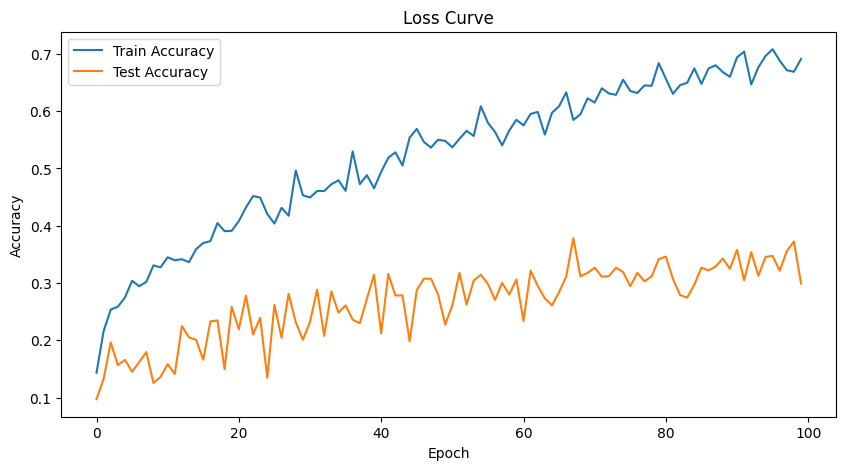

In [183]:
# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(log_acc_train, label='Train Accuracy')
plt.plot(log_acc_test, label='Test Accuracy')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./LaViT_learning_curve.png')
plt.show()

In [146]:
def get_activation(name):
    # hook will capture the layer's output (output) and store it in the activation dictionary with the specified name.
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [168]:
get_activation('layers3')

<function __main__.get_activation.<locals>.hook(model, input, output)>

In [149]:
get_activation(model.head)

<function __main__.get_activation.<locals>.hook(model, input, output)>

In [171]:
model.layer3.register_forward_hook(get_activation('layers3'))

In [172]:
model(inputs).shape

torch.Size([200, 10])

In [185]:
model.attention_feature.shape

torch.Size([200, 5, 32])

In [ ]:
train_subset = subsample_dataset(train_dataset, sample_size=sample_size)
val_subset = subsample_dataset(val_dataset, sample_size=int(sample_size * 0.2))
test_subset = subsample_dataset(cifar_test, sample_size=200)

In [197]:
train_loader_ = DataLoader(train_subset, batch_size=len(train_subset), shuffle=True)
val_loader_ = DataLoader(val_subset, batch_size=len(val_subset), shuffle=False)
test_loader_ = DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)

In [229]:
cel = nn.CrossEntropyLoss()
da = DiagonalLoss()
epoch_losses = []
epoch_accuracies = []
for step, (inputs, labels) in enumerate(val_loader_):
    test_corr, test_total = 0, 0
    model.eval()
    with torch.no_grad():
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # print(len(inputs))
        y_pred = torch.argmax(outputs, 1)
        test_corr += torch.sum(torch.eq(y_pred, labels).float()).item()
        test_total += len(inputs)
        epoch_accuracy = test_corr / test_total
        epoch_accuracies.append(epoch_accuracy)
        loss = cel(outputs, labels)
        loss += da(model.att_matrix)
        y_val = labels.detach().cpu().numpy()
        # epoch_losses.append(loss.item())
print(f"test loss: ", np.mean(loss.item()))
print(f"test acc: ", epoch_accuracy)

test loss:  912755.5625
test acc:  0.315


In [208]:
X_train = model.attention_feature

In [210]:
X_val = model.attention_feature

In [212]:
X_test = model.attention_feature

In [231]:
y_train, y_val , y_test

array([5, 4, 1, 0, 5, 6, 6, 8, 3, 6, 7, 9, 2, 6, 2, 2, 9, 6, 1, 3, 9, 0,
       4, 6, 9, 6, 6, 4, 2, 1, 4, 9, 5, 2, 5, 0, 3, 1, 5, 1, 4, 4, 0, 5,
       0, 5, 8, 0, 2, 9, 9, 6, 1, 3, 5, 0, 0, 8, 5, 6, 8, 8, 2, 3, 3, 4,
       0, 8, 5, 4, 1, 2, 9, 9, 1, 6, 9, 2, 1, 8, 7, 6, 5, 1, 7, 8, 0, 1,
       7, 4, 7, 5, 6, 6, 5, 1, 5, 4, 2, 2, 7, 8, 0, 9, 7, 3, 0, 2, 1, 6,
       9, 9, 3, 8, 5, 5, 0, 9, 9, 9, 8, 6, 2, 1, 3, 8, 9, 8, 1, 8, 0, 3,
       0, 3, 7, 6, 5, 6, 5, 0, 8, 5, 7, 0, 8, 3, 3, 2, 8, 5, 7, 1, 2, 1,
       2, 4, 0, 6, 8, 4, 0, 5, 0, 8, 4, 0, 1, 9, 1, 1, 6, 6, 6, 0, 6, 6,
       1, 0, 5, 1, 7, 1, 6, 0, 5, 3, 9, 2, 7, 6, 6, 3, 0, 7, 9, 7, 7, 4,
       5, 6])

In [253]:
X_train_ = torch.mean(X_train,dim=1)
X_val_ = torch.mean(X_val,dim=1)
X_test_ = torch.mean(X_test,dim=1)

In [275]:
X_train_ = X_train.flatten(start_dim=1,end_dim=-1)
X_val_ = X_val.flatten(start_dim=1,end_dim=-1)

In [280]:
X_train_ = X_train[:, 0, :]
X_val_ = X_val[:, 0, :]

In [216]:
train_subset[0][1]

1

In [239]:
X_train.shape

torch.Size([1000, 5, 32])

In [232]:
from sklearn.ensemble import GradientBoostingClassifier

In [233]:
gbc = GradientBoostingClassifier()

In [245]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train_.detach().cpu().numpy())

PCA(n_components=2)

In [281]:
gbc.fit(X_train_.detach().cpu().numpy(),y_train)

GradientBoostingClassifier()

In [282]:
y_pred_val_gbc = gbc.predict(X_val_.detach().cpu().numpy())

In [250]:
from sklearn.metrics import classification_report

In [283]:
print(classification_report(y_pred_val_gbc,y_val))

              precision    recall  f1-score   support

           0       0.12      0.16      0.14        19
           1       0.09      0.12      0.10        16
           2       0.00      0.00      0.00        23
           3       0.13      0.07      0.09        28
           4       0.14      0.10      0.12        20
           5       0.00      0.00      0.00        11
           6       0.04      0.07      0.05        15
           7       0.07      0.04      0.05        28
           8       0.11      0.11      0.11        18
           9       0.15      0.14      0.14        22

    accuracy                           0.08       200
   macro avg       0.08      0.08      0.08       200
weighted avg       0.09      0.08      0.08       200



In [331]:
import torch.nn.functional as F
transform = torchvision.transforms.Compose([
                                          torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=0.1307, std=0.3081),
                                            torchvision.transforms.Pad([2,2],fill=0,padding_mode='symmetric')
                                          ])

mnist_train = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform)

In [337]:
mnist_train[0][0][0].shape

torch.Size([32, 32])

In [332]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
indices = torch.randperm(len(cifar_train))
train_indices, test_indices = train_test_split(indices, train_size=0.8)
train_dataset = Subset(mnist_train, train_indices)
val_dataset = Subset(mnist_train, test_indices)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

In [333]:
sample_size = 1000
train_subset = subsample_dataset(train_dataset, sample_size=sample_size)
val_subset = subsample_dataset(val_dataset, sample_size=int(sample_size * 0.2))
test_subset = subsample_dataset(cifar_test, sample_size=200)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=200, shuffle=False)

In [338]:
import torch.optim as optim
import numpy as np
from datetime import datetime


device = "cuda"
model = ViT(ch=1).to(device)
# train_loader.to(device)
# test_loader.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
cel = nn.CrossEntropyLoss()
da = DiagonalLoss()
log_loss_train, log_acc_train, log_loss_test, log_acc_test = [], [], [], []
tick = datetime.now()

for epoch in range(100):
    train_epoch_losses = []
    train_epoch_accuracies = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    model.train()
    train_corr, train_total = 0, 0
    test_corr, test_total = 0, 0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        y_pred = torch.argmax(outputs, 1)
        train_corr += torch.sum(torch.eq(y_pred, labels).float()).item()
        train_total += len(inputs)
        epoch_accuracy = train_corr / train_total
        train_epoch_accuracies.append(epoch_accuracy)
        # print(model.att_matrix[1].shape)
        loss =  cel(outputs, labels)
        # loss += da(model.att_matrix)
        # print(loss)
        torch.autograd.set_detect_anomaly(True)
        loss.backward(retain_graph=True)
        optimizer.step()
        train_epoch_losses.append(loss.item())
    log_loss_train.append(np.mean(train_epoch_losses))
    log_acc_train.append(np.mean(train_epoch_accuracies))
    model.eval()
    with torch.no_grad():
        for step, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            y_pred = torch.argmax(outputs, 1)
            test_corr += torch.sum(torch.eq(y_pred, labels).float()).item()
            test_total += len(inputs)
            epoch_accuracy = test_corr / test_total
            test_epoch_accuracies.append(epoch_accuracy)
            loss = cel(outputs, labels)
                # loss += da(model.att_matrix)
            test_epoch_losses.append(loss.item())
    log_loss_test.append(np.mean(test_epoch_losses))
    log_acc_test.append(np.mean(test_epoch_accuracies))
    if epoch % 5 == 0:
    # if True:
        print(f">>> Epoch {epoch} - train loss: {np.mean(train_epoch_losses)} - train accuracy : {np.mean(train_epoch_accuracies)} ") 
        # epoch_losses = []
        # epoch_accuracies = []
        print(f">>> Epoch {epoch} - test loss: {np.mean(test_epoch_losses)} - test accuracy : {np.mean(test_epoch_accuracies)} ") 
    
tock = datetime.now()   

diff = tock - tick    # the result is a datetime.timedelta object
print(diff.total_seconds())

>>> Epoch 0 - train loss: 2.2382576167583466 - train accuracy : 0.17748457185175937 
>>> Epoch 0 - test loss: 2.294394850730896 - test accuracy : 0.07783854166666668 
>>> Epoch 5 - train loss: 1.7880780920386314 - train accuracy : 0.7505080149884837 
>>> Epoch 5 - test loss: 1.9244912266731262 - test accuracy : 0.5123177083333333 
>>> Epoch 10 - train loss: 1.668965883553028 - train accuracy : 0.7957001183495325 
>>> Epoch 10 - test loss: 1.9207293391227722 - test accuracy : 0.5960677083333333 
>>> Epoch 15 - train loss: 1.6399763375520706 - train accuracy : 0.834703063646423 
>>> Epoch 15 - test loss: 1.8016504049301147 - test accuracy : 0.716015625 
>>> Epoch 20 - train loss: 1.598366655409336 - train accuracy : 0.8766013418005605 
>>> Epoch 20 - test loss: 1.7372629344463348 - test accuracy : 0.775390625 
>>> Epoch 25 - train loss: 1.5446895137429237 - train accuracy : 0.9268330959405178 
>>> Epoch 25 - test loss: 1.6563956439495087 - test accuracy : 0.8120833333333334 
>>> Epoch 30

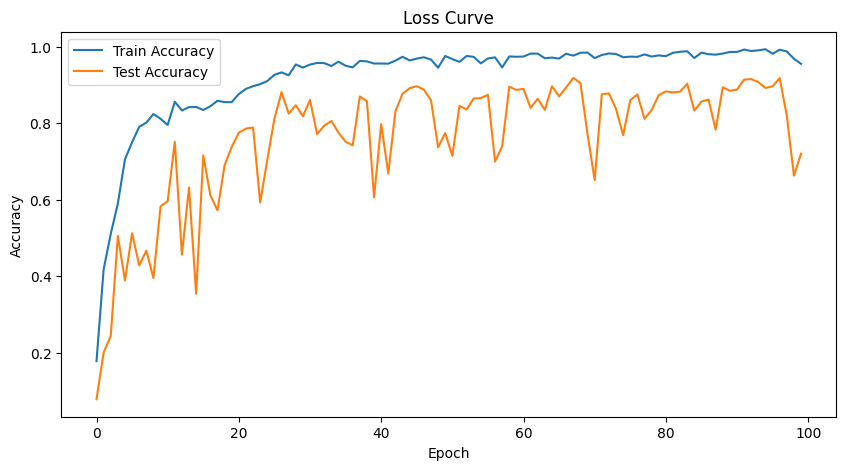

In [339]:
# Plot the training and test loss
plt.figure(figsize=(10, 5))
plt.plot(log_acc_train, label='Train Accuracy')
plt.plot(log_acc_test, label='Test Accuracy')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./LaViT_learning_curve_mnist.png')
plt.show()

In [341]:
cel = nn.CrossEntropyLoss()
da = DiagonalLoss()
epoch_losses = []
epoch_accuracies = []
for step, (inputs, labels) in enumerate(val_loader):
    test_corr, test_total = 0, 0
    model.eval()
    with torch.no_grad():
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        # print(len(inputs))
        y_pred = torch.argmax(outputs, 1)
        test_corr += torch.sum(torch.eq(y_pred, labels).float()).item()
        test_total += len(inputs)
        epoch_accuracy = test_corr / test_total
        epoch_accuracies.append(epoch_accuracy)
        loss = cel(outputs, labels)
        loss += da(model.att_matrix)
        # y_val = labels.detach().cpu().numpy()
        # epoch_losses.append(loss.item())
print(f"test loss: ", np.mean(loss.item()))
print(f"test acc: ", epoch_accuracy)

test loss:  30556.119140625
test acc:  0.625


In [343]:
model.attention_feature.shape

torch.Size([8, 5, 32])